In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import os
import random
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
TRAINING_SIZE = 20000
TESTING_SIZE = 5000
NUM_LOADED_SAMPLES = TRAINING_SIZE + TESTING_SIZE
INPUT_SHAPE = (None, None, 1)
LEARNING_RATE = 0.0001
EPOCHS = 400
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 12
DATA_FOLDER_NAME = './data/'
MODEL_FOLDER_NAME = './weights/'
SAMPLE_FOLDER_NAME = './samples/'

In [5]:
gray_npy = np.load(DATA_FOLDER_NAME+"l/gray_scale.npy")
ab1_NPY = np.load(DATA_FOLDER_NAME+"ab/ab/ab1.npy") #10k
ab2_NPY = np.load(DATA_FOLDER_NAME+"ab/ab/ab2.npy") #10k
ab3_NPY = np.load(DATA_FOLDER_NAME+"ab/ab/ab3.npy") #5k

training_target = np.concatenate([ab1_NPY, ab2_NPY])

X_train = gray_npy[0:TRAINING_SIZE]
Y_train = training_target[0:TRAINING_SIZE].astype(np.float32)

X_test = gray_npy[20000:(20000+TESTING_SIZE)]
Y_test = ab3_NPY[0:TESTING_SIZE].astype(np.float32)


In [6]:
print(gray_npy.shape)
print(training_target.shape)
print('')
print(X_train.shape)
print(Y_train.shape)
print('')
print(X_test.shape)
print(Y_test.shape)

(25000, 224, 224)
(20000, 224, 224, 2)

(20000, 224, 224)
(20000, 224, 224, 2)

(5000, 224, 224)
(5000, 224, 224, 2)


In [5]:
# LAB -> rgb
def lab_to_rgb(image_l, image_ab):
    image_l = image_l.reshape((image_l.shape[0], image_l.shape[1], 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    return image_rgb

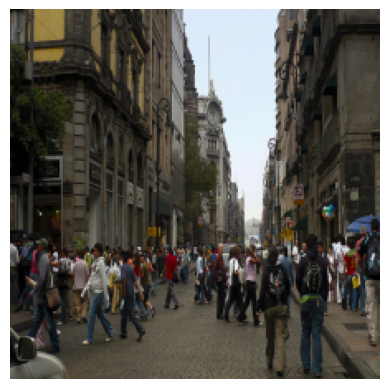

In [23]:
#indices = [8705, 9485, 1667, 37, 8355]
indices = [1667]

for index in indices:
    rgb_image = lab_to_rgb(gray_npy[index],ab1_NPY[index])
    plt.imshow(rgb_image)
    plt.axis('off')
    #plt.imsave(f'{index}.png', rgb_image)
    plt.show()
    

In [ ]:
# Total params: 3099714 (11.82 MB)
# Trainable params: 3099714 (11.82 MB)
# autoencode.h5

# A simple autoencoder
# Model A

def create_model_1(X_train, Y_train):

    # Input layer
    input_layer = keras.Input(shape=INPUT_SHAPE)

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)

    model = keras.Model(inputs=input_layer, outputs=x)

    model.compile(
            optimizer=keras.optimizers.Adam(epsilon=LEARNING_RATE),
            loss="mean_squared_error",
            metrics="mean_absolute_error",
    )
    
    return model

In [ ]:
# 7M parameters
# unet-7m-1.h5

# The first iteration of unet-architectures
# Model B

def create_model_2(X_train, Y_train): 
    dropout_rate = 0.0
    
    # Input layer (INPUT_SHAPE = (None, None, 1))
    input_layer = keras.Input(shape=INPUT_SHAPE)

    # Encoder
    # 224 x 224
    e1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='e1')(input_layer)
    
    # 112 x 112
    e2 = layers.MaxPooling2D()(e1)
    e2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='e2')(e2)
    
    # 56 x 56
    e3 = layers.MaxPooling2D()(e2)
    e3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='e3')(e3)
    
    # 28 x 28
    e4 = layers.MaxPooling2D()(e3)
    e4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='e4')(e4)
    
    # 14 x 14
    e5 = layers.MaxPooling2D()(e4)
    e5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='e5')(e5)

    # Decoder
    # 28 x 28
    d1 = layers.UpSampling2D(size=(2, 2))(e5)
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='d1')(d1)
    d1 = layers.concatenate([e4, d1], name='d1_concat')
    d1 = layers.Dropout(dropout_rate)(d1)
    
    # 56 x 56
    d2 = layers.UpSampling2D(size=(2, 2))(d1)
    d2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='d2')(d2)
    d2 = layers.concatenate([e3, d2], name='d2_concat')
    d2 = layers.Dropout(dropout_rate)(d2)
    
    # 112 x 112
    d3 = layers.UpSampling2D(size=(2, 2))(d2)
    d3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='d3')(d3)
    d3 = layers.concatenate([e2, d3], name='d3_concat')
    d3 = layers.Dropout(dropout_rate)(d3)
    
    # 224 x 224
    d4 = layers.UpSampling2D(size=(2, 2))(d3)
    d4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='d4')(d4)
    d4 = layers.concatenate([e1, d4], name='d4_concat')
    d4 = layers.Dropout(dropout_rate)(d4)
    
    # 224 x 224
    output_layer = layers.Conv2D(2, (1, 1), activation='relu', padding='same')(d4)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(
            optimizer=keras.optimizers.Adam(epsilon=LEARNING_RATE),
            loss="mean_squared_error",
            metrics="mean_absolute_error",
    )
    
    return model

In [ ]:
# 14,085,826 parameters
# unet-7m-14M.h5

# Quadrupled the depth of the latent space
# Model C

def create_model_3(X_train, Y_train): 
    dropout_rate = 0.0
    
    # Input layer (INPUT_SHAPE = (None, None, 1))
    input_layer = keras.Input(shape=INPUT_SHAPE)

    # Encoder
    # 224 x 224
    e1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='e1')(input_layer)
    
    # 112 x 112
    e2 = layers.MaxPooling2D()(e1)
    e2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='e2')(e2)
    
    # 56 x 56
    e3 = layers.MaxPooling2D()(e2)
    e3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='e3')(e3)
    
    # 28 x 28
    e4 = layers.MaxPooling2D()(e3)
    e4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='e4')(e4)
    
    # 14 x 14
    e5 = layers.MaxPooling2D()(e4)
    e5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same', name='e5')(e5)

    # Decoder
    # 28 x 28
    d1 = layers.UpSampling2D(size=(2, 2))(e5)
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='d1')(d1)
    d1 = layers.concatenate([e4, d1], name='d1_concat')
    d1 = layers.Dropout(dropout_rate)(d1)
    
    # 56 x 56
    d2 = layers.UpSampling2D(size=(2, 2))(d1)
    d2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='d2')(d2)
    d2 = layers.concatenate([e3, d2], name='d2_concat')
    d2 = layers.Dropout(dropout_rate)(d2)
    
    # 112 x 112
    d3 = layers.UpSampling2D(size=(2, 2))(d2)
    d3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='d3')(d3)
    d3 = layers.concatenate([e2, d3], name='d3_concat')
    d3 = layers.Dropout(dropout_rate)(d3)
    
    # 224 x 224
    d4 = layers.UpSampling2D(size=(2, 2))(d3)
    d4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='d4')(d4)
    d4 = layers.concatenate([e1, d4], name='d4_concat')
    d4 = layers.Dropout(dropout_rate)(d4)
    
    # 224 x 224
    output_layer = layers.Conv2D(2, (1, 1), activation='relu', padding='same')(d4)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(
            optimizer=keras.optimizers.Adam(epsilon=LEARNING_RATE),
            loss="mean_squared_error",
            metrics="mean_absolute_error",
    )
    
    return model

In [ ]:
# 4,853,384 M
# unet-batchnorm.h5

# Downscaled the depth, dilation rate = 2, and added an extra layer for the latent space
# Also added batch normalization
# Model D

def create_model_4(X_train, Y_train): 
    dropout_rate = 0.0
    
    # Input layer (INPUT_SHAPE = (None, None, 1))
    input_layer = keras.Input(shape=INPUT_SHAPE)

    # Encoder
    # 224 x 224 input
    e1 = layers.Conv2D(32, (4, 4), strides=2, padding='same', name='e1')(input_layer)
    e1 = layers.BatchNormalization()(e1)
    e1 = layers.Activation('relu')(e1)

    # 112 x 112 input
    e2 = layers.Conv2D(64, (4, 4), strides=2, padding='same', name='e2')(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.Activation('relu')(e2)

    # 56 x 56 input
    e3 = layers.Conv2D(128, (4, 4), strides=2, padding='same', name='e3')(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.Activation('relu')(e3)

    # 28 x 28 input
    e4 = layers.Conv2D(256, (4, 4), strides=2, padding='same', name='e4')(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.Activation('relu')(e4)
    
    # 14 x 14 input
    e5 = layers.Conv2D(256, (4, 4), dilation_rate=2, strides=1, padding='same', name='e5')(e4)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)

    # 14 x 14 input
    e5 = layers.Conv2D(256, (4, 4), dilation_rate=2, strides=1, padding='same')(e5)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)

    # Decoder
    # 28 x 28 output
    d1 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', name='d1')(e5)
    d1 = layers.concatenate([e3, d1], name='d1_concat')
    d1 = layers.Dropout(dropout_rate)(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Activation('relu')(d1)

    # 56 x 56 output
    d2 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', name='d2')(d1)
    d2 = layers.concatenate([e2, d2], name='d2_concat')
    d2 = layers.Dropout(dropout_rate)(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Activation('relu')(d2)

    # 112 x 112 output
    d3 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', name='d3')(d2)
    d3 = layers.concatenate([e1, d3], name='d3_concat')
    d3 = layers.Dropout(dropout_rate)(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Activation('relu')(d3)

    # 224 x 224 output
    d4 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', name='d4')(d3)
    d4 = layers.concatenate([input_layer, d4], name='d4_concat')
    d4 = layers.Dropout(dropout_rate)(d4)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.Activation('relu')(d4)

    # 224 x 224 output
    output_layer = layers.Conv2D(2, (1, 1), activation='relu', padding='same')(d4)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(
            optimizer=keras.optimizers.Adam(epsilon=LEARNING_RATE),
            loss="mean_squared_error",
            metrics="mean_absolute_error",
    )
    
    return model

In [ ]:
# 4853384
# unet-batchnorm-drop-reg.h5

# Added dropout in the decoder and regularization in the latent space
# Model E

def create_model_5(X_train, Y_train): 
    dropout_rate = 0.2
    regularization_strength=0.01
    
    # Input layer (INPUT_SHAPE = (None, None, 1))
    input_layer = keras.Input(shape=INPUT_SHAPE)

    # Encoder
    # 224 x 224 input
    e1 = layers.Conv2D(32, (4, 4), strides=2, padding='same', name='e1')(input_layer)
    e1 = layers.BatchNormalization()(e1)
    e1 = layers.Activation('relu')(e1)

    # 112 x 112 input
    e2 = layers.Conv2D(64, (4, 4), strides=2, padding='same', name='e2')(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.Activation('relu')(e2)

    # 56 x 56 input
    e3 = layers.Conv2D(128, (4, 4), strides=2, padding='same', name='e3')(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.Activation('relu')(e3)

    # 28 x 28 input
    e4 = layers.Conv2D(256, (4, 4), strides=2, padding='same', name='e4')(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.Activation('relu')(e4)
    
    # 14 x 14 input
    e5 = layers.Conv2D(256, (4, 4), dilation_rate=2, strides=1, padding='same', name='e5', kernel_regularizer=regularizers.l2(regularization_strength))(e4)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)

    # 14 x 14 input
    e5 = layers.Conv2D(256, (4, 4), dilation_rate=2, strides=1, padding='same',kernel_regularizer=regularizers.l2(regularization_strength))(e5)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)

    # Decoder
    # 28 x 28 output
    d1 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', name='d1')(e5)
    d1 = layers.concatenate([e3, d1], name='d1_concat')
    d1 = layers.Dropout(dropout_rate)(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Activation('relu')(d1)

    # 56 x 56 output
    d2 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', name='d2')(d1)
    d2 = layers.concatenate([e2, d2], name='d2_concat')
    d2 = layers.Dropout(dropout_rate)(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Activation('relu')(d2)

    # 112 x 112 output
    d3 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', name='d3')(d2)
    d3 = layers.concatenate([e1, d3], name='d3_concat')
    d3 = layers.Dropout(dropout_rate)(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Activation('relu')(d3)

    # 224 x 224 output
    d4 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', name='d4')(d3)
    d4 = layers.concatenate([input_layer, d4], name='d4_concat')
    d4 = layers.Dropout(dropout_rate)(d4)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.Activation('relu')(d4)

    # 224 x 224 output
    output_layer = layers.Conv2D(2, (1, 1), activation='relu', padding='same')(d4)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(
            optimizer=keras.optimizers.Adam(epsilon=LEARNING_RATE),
            loss="mean_squared_error",
            metrics="mean_absolute_error",
    )
    
    return model

In [ ]:
# Total params: 9554894
# Trainable params: 7292492
# unet-mobilenet.h5

# Added mobile net and decreased the size of the latent space to accept mobilenet output
# Model F

def create_model_6(X_train, Y_train): 
    # Load MobileNetV2 as a pretrained model
    pretrained_model = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pretrained model
    for layer in pretrained_model.layers:
        layer.trainable = False
        
        
    input_layer = keras.Input(shape=(224, 224, 1))
        
    input_rgb = layers.Conv2D(3, (1, 1), padding='same', activation='relu')(input_layer)
    pretrained_output = pretrained_model(input_rgb)

    dropout_rate = 0.0
    regularization_strength=0.00

    # Encoder
    # 224 x 224 input
    e1 = layers.Conv2D(32, (4, 4), strides=2, padding='same', name='e1')(input_layer)
    e1 = layers.BatchNormalization()(e1)
    e1 = layers.Activation('relu')(e1)

    # 112 x 112 input
    e2 = layers.Conv2D(64, (4, 4), strides=2, padding='same', name='e2')(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.Activation('relu')(e2)

    # 56 x 56 input
    e3 = layers.Conv2D(128, (4, 4), strides=2, padding='same', name='e3')(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.Activation('relu')(e3)

    # 28 x 28 input
    e4 = layers.Conv2D(256, (4, 4), strides=2, padding='same', name='e4')(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.Activation('relu')(e4)
    
    # 14 x 14 input
    e5 = layers.Conv2D(256, (4, 4), strides=2, padding='same', name='e5', kernel_regularizer=regularizers.l2(regularization_strength))(e4)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)
    
    # 7 x 7 input
    e5 = layers.Conv2D(128, (3, 3), padding='same', dilation_rate=2, kernel_regularizer=regularizers.l2(regularization_strength))(e5)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)
    
    # 7 x 7 input
    e5 = layers.concatenate([e5, pretrained_output], name='latent')
    # 7 x 7 output
    
    # 7 x 7 output
    e5 = layers.Conv2D(128, (3, 3), padding='same', dilation_rate=2, kernel_regularizer=regularizers.l2(regularization_strength))(e5)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)
    
    # Decoder
    # 14 x 14 output
    d1 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', name='d1')(e5)
    d1 = layers.concatenate([e4, d1], name='d1_concat')
    d1 = layers.Dropout(dropout_rate)(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Activation('relu')(d1)

    # 28 x 28 output
    d2 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', name='d2')(d1)
    d2 = layers.concatenate([e3, d2], name='d2_concat')
    d2 = layers.Dropout(dropout_rate)(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Activation('relu')(d2)

    # 56 x 56 output
    d3 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', name='d3')(d2)
    d3 = layers.concatenate([e2, d3], name='d3_concat')
    d3 = layers.Dropout(dropout_rate)(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Activation('relu')(d3)

    # 112 x 112 output
    d4 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', name='d4')(d3)
    d4 = layers.concatenate([e1, d4], name='d4_concat')
    d4 = layers.Dropout(dropout_rate)(d4)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.Activation('relu')(d4)

    # 224 x 224 output
    d5 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', name='d5')(d4)
    d5 = layers.concatenate([input_layer, d5], name='d5_concat')
    d5 = layers.Dropout(dropout_rate)(d5)
    d5 = layers.BatchNormalization()(d5)
    d5 = layers.Activation('relu')(d5)

    # 224 x 224 output
    output_layer = layers.Conv2D(2, (1, 1), activation='relu', padding='same')(d5)

    # Create the model
    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(
            optimizer=keras.optimizers.Adam(epsilon=LEARNING_RATE),
            loss="mean_squared_error",
            metrics="mean_absolute_error",
    )
    
    return model

In [ ]:
def perceptual_loss(y_true, y_pred):
    patches_true = tf.image.extract_patches(
        images=y_true,
        sizes=[1, 3, 3, 1], # Patch sizes of 3x3 will be extracted from each image.
        strides=[1, 1, 1, 1], # patches will be extracted with a stride of 1 in all dimensions.
        rates=[1, 1, 1, 1], # The dilation rate for extracting patches. [1, 1, 1, 1] means no dilation is applied.
        padding='SAME'
    )
    patches_pred = tf.image.extract_patches(
        images=y_pred,
        sizes=[1, 3, 3, 1],
        strides=[1, 1, 1, 1],
        rates=[1, 1, 1, 1],
        padding='SAME'
    )

    # Reshape patches to ensure fully defined shape
    patches_true = tf.reshape(patches_true, [tf.shape(patches_true)[0], -1, tf.shape(patches_true)[-1]])
    patches_pred = tf.reshape(patches_pred, [tf.shape(patches_pred)[0], -1, tf.shape(patches_pred)[-1]])

    # Compute perceptual loss
    # The perceptual loss is computed as the mean squared difference between the true and predicted patches.
    # tf.square computes the element-wise square of the difference between the patches
    # tf.reduce_mean calculates the mean of these squared differences across all patches
    loss = K.mean(K.square(true_features - pred_features))
    return loss

# Model G

def create_model_7(X_train, Y_train): 
    input_layer = Input(shape=INPUT_SHAPE)
    #input_layer = Input(shape=(224, 224, 1))
    
    dropout_rate = 0

    # Encoder
    # 224 x 224 input
    e1 = layers.Conv2D(32, (4, 4), strides=2, padding='same', name='e1')(input_layer)
    e1 = layers.BatchNormalization()(e1)
    e1 = layers.Activation('relu')(e1)

    # 112 x 112 input
    e2 = layers.Conv2D(64, (4, 4), strides=2, padding='same', name='e2')(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.Activation('relu')(e2)

    # 56 x 56 input
    e3 = layers.Conv2D(128, (4, 4), strides=2, padding='same', name='e3')(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.Activation('relu')(e3)

    # 28 x 28 input
    e4 = layers.Conv2D(256, (4, 4), strides=2, padding='same', name='e4')(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.Activation('relu')(e4)
    
    # 14 x 14 input
    e5 = layers.Conv2D(256, (4, 4), dilation_rate=2, strides=1, padding='same', name='e5')(e4)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)

    # 14 x 14 input
    e5 = layers.Conv2D(256, (4, 4), dilation_rate=2, strides=1, padding='same')(e5)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)

    # Decoder
    # 28 x 28 output
    d1 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', name='d1')(e5)
    d1 = layers.concatenate([e3, d1], name='d1_concat')
    d1 = layers.Dropout(dropout_rate)(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Activation('relu')(d1)

    # 56 x 56 output
    d2 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', name='d2')(d1)
    d2 = layers.concatenate([e2, d2], name='d2_concat')
    d2 = layers.Dropout(dropout_rate)(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Activation('relu')(d2)

    # 112 x 112 output
    d3 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', name='d3')(d2)
    d3 = layers.concatenate([e1, d3], name='d3_concat')
    d3 = layers.Dropout(dropout_rate)(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Activation('relu')(d3)

    # 224 x 224 output
    d4 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', name='d4')(d3)
    d4 = layers.concatenate([input_layer, d4], name='d4_concat')
    d4 = layers.Dropout(dropout_rate)(d4)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.Activation('relu')(d4)

    # 224 x 224 output
    output_layer = layers.Conv2D(2, (1, 1), activation='relu', padding='same')(d4)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(
            optimizer=keras.optimizers.Adam(epsilon=LEARNING_RATE),
            loss=perceptual_loss,
            metrics=["mean_squared_error"],
    )
    
    return model

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, Input

vgg19 = VGG19(include_top=False, input_shape=(224,224,3))
vgg19.trainable = False
for layer in vgg19.layers:
    layer.trainable = False
vgg19_model = Sequential()
for layer in vgg19.layers[:-1]:
    vgg19_model.add(layer)
vgg19_model.trainable = False

def deep_perceptual_loss(y_true, y_pred):
    true_features = vgg19_model(y_true)
    pred_features = vgg19_model(y_pred)
    loss = tf.reduce_mean(tf.square(true_features - pred_features))
    return loss

# Model H

def create_model_8(X_train, Y_train): 
    input_layer = Input(shape=INPUT_SHAPE)
    #input_layer = Input(shape=(224, 224, 1))
    
    dropout_rate = 0

    # Encoder
    # 224 x 224 input
    e1 = layers.Conv2D(32, (4, 4), strides=2, padding='same', name='e1')(input_layer)
    e1 = layers.BatchNormalization()(e1)
    e1 = layers.Activation('relu')(e1)

    # 112 x 112 input
    e2 = layers.Conv2D(64, (4, 4), strides=2, padding='same', name='e2')(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.Activation('relu')(e2)

    # 56 x 56 input
    e3 = layers.Conv2D(128, (4, 4), strides=2, padding='same', name='e3')(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.Activation('relu')(e3)

    # 28 x 28 input
    e4 = layers.Conv2D(256, (4, 4), strides=2, padding='same', name='e4')(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.Activation('relu')(e4)
    
    # 14 x 14 input
    e5 = layers.Conv2D(256, (4, 4), dilation_rate=2, strides=1, padding='same', name='e5')(e4)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)

    # 14 x 14 input
    e5 = layers.Conv2D(256, (4, 4), dilation_rate=2, strides=1, padding='same')(e5)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation('relu')(e5)

    # Decoder
    # 28 x 28 output
    d1 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', name='d1')(e5)
    d1 = layers.concatenate([e3, d1], name='d1_concat')
    d1 = layers.Dropout(dropout_rate)(d1)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Activation('relu')(d1)

    # 56 x 56 output
    d2 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', name='d2')(d1)
    d2 = layers.concatenate([e2, d2], name='d2_concat')
    d2 = layers.Dropout(dropout_rate)(d2)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Activation('relu')(d2)

    # 112 x 112 output
    d3 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', name='d3')(d2)
    d3 = layers.concatenate([e1, d3], name='d3_concat')
    d3 = layers.Dropout(dropout_rate)(d3)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Activation('relu')(d3)

    # 224 x 224 output
    d4 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', name='d4')(d3)
    d4 = layers.concatenate([input_layer, d4], name='d4_concat')
    d4 = layers.Dropout(dropout_rate)(d4)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.Activation('relu')(d4)

    # 224 x 224 output
    output_layer = layers.Conv2D(2, (1, 1), activation='relu', padding='same')(d4)
    output_layer = layers.concatenate([input_layer, output_layer])

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(
            optimizer=keras.optimizers.Adam(epsilon=LEARNING_RATE),
            loss=deep_perceptual_loss,
            metrics=["mean_squared_error"],
    )
    
    return model

In [ ]:
model = create_model_7(X_train, Y_train)
model.summary()

# If model 8 is being trained:
#X_train_reshaped = np.expand_dims(X_train, axis=-1)
#Y_train_concatenated = np.concatenate([X_train_reshaped, Y_train], axis=-1)

#early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    #callbacks=[early_stopping]
)

In [ ]:
history_data = model_history.history

# Plotting the training loss and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_data['mean_absolute_error'][5:], label='Training MAE')
plt.plot(history_data['val_mean_absolute_error'][5:], label='Validation MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
def resize_to_closest_acceptible(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Get the original dimensions
    original_height, original_width = img.shape
    
    closest_acceptable = 16
    
    # Calculate the new dimensions
    new_width = (original_width // closest_acceptable) * closest_acceptable
    new_height = (original_height // closest_acceptable) * closest_acceptable

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height))
    return resized_img

def show_training_result(model, X_train, Y_train, training=True):
    if training:
        index = random.randint(0, TRAINING_SIZE-0.2*TRAINING_SIZE-1)
    else:
        index = random.randint(TRAINING_SIZE-0.2*TRAINING_SIZE, TRAINING_SIZE)
        
    print("Index:", index)
        
    input_image = X_train[index]
    
    print("INPUT IMAGE SIZE:", input_image.shape)


    fig, axes = plt.subplots(1, 3, figsize=(16, 16))

    # Plot grayscale image
    axes[0].imshow(input_image, cmap="gray")
    axes[0].axis('off')
    axes[0].set_title('Grayscale Image')

    # Plot color image
    axes[1].imshow(lab_to_rgb(input_image, Y_train[index]))
    axes[1].axis('off')
    split_name = "Training " if training else "Validation "
    axes[1].set_title(split_name + 'Color Image')
    # Plot Prediciton
    prediction = model.predict(np.array([input_image]))[0]

    print(prediction.shape)
    prediction_image = lab_to_rgb(input_image, prediction)
    axes[2].imshow(prediction_image)
    axes[2].axis('off')
    axes[2].set_title('Prediction')

    plt.show()


def show_testing_result(model, resize=False, test_image_path="../input/flag-photo/flag.jpg"):
    if resize:
        test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
        test_image = cv2.resize(test_image, (224, 224))
    else:
        test_image = resize_to_closest_acceptible(test_image_path)
    print(test_image.shape)

    fig, axes = plt.subplots(1, 2, figsize=(16, 16))
    axes[0].imshow(test_image, cmap="gray")
    axes[0].axis('off')
    axes[0].set_title('Grayscale Image')

    prediction = model.predict(np.array([test_image]))[0]
    prediction = cv2.resize(prediction, (test_image.shape[1], test_image.shape[0]))
    print(prediction.shape)
    prediction_image = lab_to_rgb(test_image, prediction)
    axes[1].imshow(prediction_image)
    axes[1].axis('off')
    axes[1].set_title('Prediction')

    plt.show()

    
def show_results(model_name, X_train, Y_train, test_image_path="./samples/flag.jpg"):
    model_dir_path = "/weights/"
    model_path = model_dir_path + model_name
    model = keras.saving.load_model(model_path)
    
    if model_name == 'unet-mobilenet.h5':
        resize = True
    else:
        resize = False
    
    show_training_result(model, X_train, Y_train, training=True)
    show_training_result(model, X_train, Y_train, training=False)
    show_testing_result(model, resize)
    

In [7]:
def show_all_model_predictions_test(model_names, X_test, Y_test, test_index = 0, title = 'Validation'):
    num_models = len(model_names)
    fig, axes = plt.subplots(2, 5, figsize=(12, 7))

    test_image = X_test[test_index]
    
    axes[0, 0].imshow(test_image, cmap="gray")
    axes[0, 0].axis('off')
    axes[0, 0].set_title(f'Grayscale {title} Image')

    axes[0, 1].imshow(lab_to_rgb(test_image, Y_test[test_index]))
    axes[0, 1].axis('off')
    axes[0, 1].set_title('Ground Truth Color Image')
    
    row_index = 0
    col_index = 2
    
    model_alph_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    
    for i, model_name in enumerate(model_names):
        if col_index == 5:
            col_index = 0
            row_index += 1
        model_letter_name = model_alph_names[i]
        model_path = "./weights/" + model_name
        model = keras.models.load_model(model_path, compile=False)
        prediction = model.predict(np.array([test_image]))[0]
        if model_letter_name == 'H':
            prediction = prediction[:, :, 1:]
        prediction_image = lab_to_rgb(test_image, prediction)
        axes[row_index, col_index].imshow(prediction_image)
        axes[row_index, col_index].axis('off')
        #title = f'Prediction - {model_name}'
        title = f'Model {model_letter_name} Prediction'
        axes[row_index, col_index].set_title(title)
        col_index += 1

    plt.tight_layout()
    plt.show()
    

def show_all_model_predictions_in_the_wild(model_names, test_image_path):
    num_models = len(model_names)
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    test_image = resize_to_closest_acceptible(test_image_path)
    test_image = cv2.resize(test_image, (224, 224))
    
    axes[0, 0].imshow(test_image, cmap="gray")
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Grayscale Historical Image')
    
    row_index = 0
    col_index = 1
    
    model_alph_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    
    for i, model_name in enumerate(model_names):
        if col_index == 3:
            col_index = 0
            row_index += 1
        model_letter_name = model_alph_names[i]
        model_path = "./weights/" + model_name
        model = keras.models.load_model(model_path, compile=False)
        prediction = model.predict(np.array([test_image]))[0]
        prediction = cv2.resize(prediction, (test_image.shape[1], test_image.shape[0]))
        if model_letter_name == 'H':
            prediction = prediction[:, :, 1:]
        prediction_image = lab_to_rgb(test_image, prediction)
        axes[row_index, col_index].imshow(prediction_image)
        axes[row_index, col_index].axis('off')
        #title = f'Prediction - {model_name}'
        title = f'Model {model_letter_name} Prediction'
        axes[row_index, col_index].set_title(title)
        col_index += 1
        
    #plt.delaxes(axes[0,1])

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 205ms/step


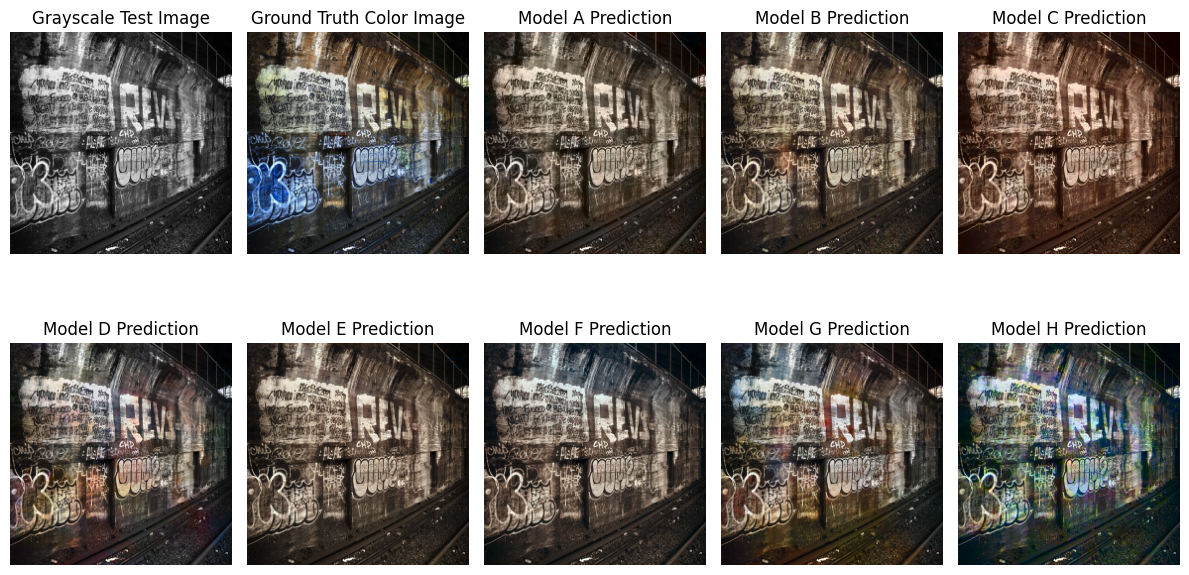

1/1 [==============================] - 0s 199ms/step


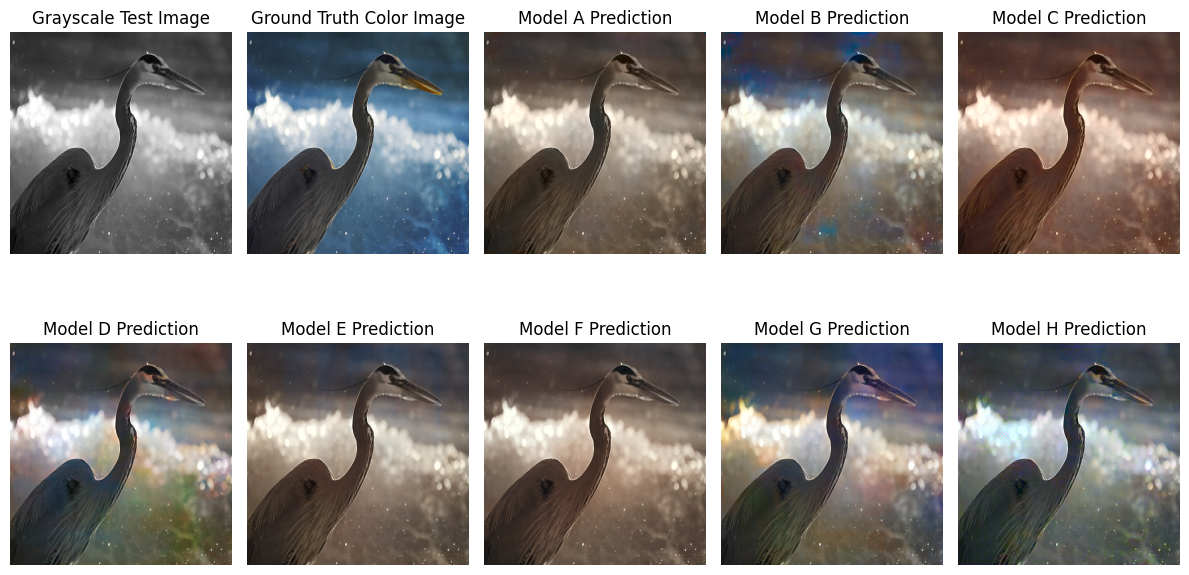

1/1 [==============================] - 0s 195ms/step


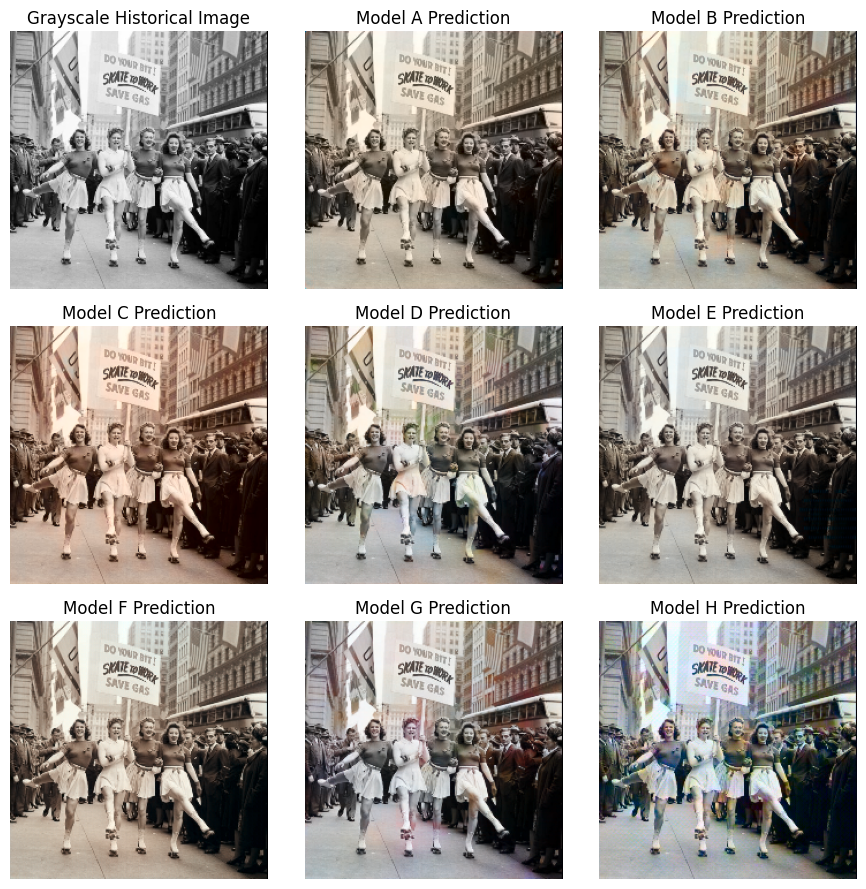

In [8]:
model_names = [
    "autoencoder.h5",              
    "unet-7m-1.h5",                
    "unet-7m-14M.h5",              
    "unet-batchnorm.h5",           
    "unet-batchnorm-drop-reg.h5",  
    'unet-mobilenet-1.h5',
    'unet-pips.h5',
    'unet-deep-pips.h5'
]        

# [8705, 9485, 1667, 37, 8355] val
# [2850, 143, 2742, 4978, 2776, 4750, 1741, 2104, 2128] test

#test_index = random.randint(0, TESTING_SIZE)

val_index = 9485
test_index_1 = 2104
test_index_2 = 2128
#show_all_model_predictions_test(model_names, X_train, Y_train, test_index=val_index, title='Validation')
show_all_model_predictions_test(model_names, X_test, Y_test, test_index=test_index_1, title='Test')
show_all_model_predictions_test(model_names, X_test, Y_test, test_index=test_index_2, title='Test')
show_all_model_predictions_in_the_wild(model_names, test_image_path=f"./samples/hist.JPG")

In [ ]:
for model_name in model_names:
    print(model_name)
    show_results(model_name, X_train, Y_train)
    print("=" * 200)
    print("")

In [37]:
def evaluation(model_name, X_test, Y_test):
    model_dir_path = "./weights/"
    model_path = model_dir_path + model_name
    model = keras.models.load_model(model_path, compile=False)
    
    # Make predictions for the entire X_test
    predictions = model.predict(X_test)
    if model_name in ['unet-deep-pips.h5']:
        predictions = predictions[:, :, :, 1:]
    
    mse_list = []
    mae_list = []
    
    for index in range(len(X_test)):
        target = Y_test[index]
        prediction = predictions[index]
        
        # Flatten the target and prediction arrays
        target_flat = target.flatten()
        prediction_flat = prediction.flatten()
        
        # Calculate MSE
        mse = mean_squared_error(target_flat, prediction_flat)
        mse_list.append(mse)
        
        # Calculate MAE
        mae = mean_absolute_error(target_flat, prediction_flat)
        mae_list.append(mae)
        
    # Compute average MSE and MAE
    avg_mse = sum(mse_list) / len(mse_list)
    avg_mae = sum(mae_list) / len(mae_list)
    
    return avg_mse, avg_mae

def evaluation_all_models(model_names, X_test, Y_test):
    results = {'Model': [], 'MSE': [], 'MAE': []}

    model_alph_names = ['A', 'B', 'C', 'D', 'E', 'F']
    
    for i, model_name in enumerate(model_names):
        avg_mse, avg_mae = evaluation(model_name, X_test, Y_test)
        results['Model'].append(model_alph_names[i])
        results['MSE'].append(round(avg_mse, 2))
        results['MAE'].append(round(avg_mae, 2))
    
    df = pd.DataFrame(results)
    return df

In [ ]:
# 5k test set
evaluation_all_models(model_names, X_test, Y_test)

In [3]:
eval_output = {
    'Model': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
    'MSE': [308.82, 298.32, 340.01, 327.41, 301.40, 303.09, 326.15, 384.12],
    'MAE': [11.40, 11.20, 13.66, 11.73, 11.52, 11.57, 11.76, 13.26]
}

df = pd.DataFrame(eval_output)
df.set_index('Model', inplace=True)
display(df)

MSE    MAE
Model               
A      308.82  11.40
B      298.32  11.20
C      340.01  13.66
D      327.41  11.73
E      301.40  11.52
F      303.09  11.57
G      326.15  11.76
H      384.12  13.26

In [ ]:
#model.save(f'autoencoder.h5')
#model.save(f'unet-mobilenet.h5')
#model.save(f'unet-mobilenet-1.h5')
#model.save(f'unet-batchnorm-drop-reg.h5')
#model.save(f'unet-batchnorm.h5')
#model.save(f'unet-7m-14M.h5')
#model.save(f'unet-7m-1.h5')
#model.save(f'unet-7m')

In [ ]:
from keras.models import load_model
model = load_model('./weights/unet-batchnorm.h5')
tf.keras.utils.plot_model(model)